In [27]:
# ECE60146 HW4
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import seaborn as sn 
import random

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

# torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Function for preparing the training data
def prepData(rawDataDir, hwDataDir):
    
    coco = COCO('{}/annotations/instances_train2014.json'.format(rawDataDir)) 
    
    catIds = coco.getCatIds(catNms=['airplane','bus','cat','dog','pizza'])
    
    for catCount,catId in enumerate(catIds):
        
        ImgIds = coco.getImgIds(catIds=catId)
        random.shuffle(ImgIds)
        
        for imgCount,imgId in enumerate(ImgIds):
            
            imgName = coco.loadImgs(imgId)[0]['file_name']
            img = Image.open(rawDataDir+'/'+imgName)
            
            if img.mode != "RGB":
                img = img.convert(mode="RGB")
            img = img.resize((64, 64), Image.BOX)
            
            
            # Save training and validation images
            if imgCount<1500:
                
                imgNewName = str(catCount*1500+imgCount) + '.jpg'
                fp = open('{}/train/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                
            elif imgCount<2000:
                
                imgNewName = str(catCount*500+imgCount-1500) + '.jpg'
                fp = open('{}/val/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                
            else:
                break
                
    return

# The Dataset class for hw4
class hwDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, tasktype):
        super().__init__()
        self.root = root
        self.tasktype = tasktype
        
    def __len__(self):
        if self.tasktype == 'training':
            return 7500
        
        if self.tasktype == 'validation':
            return 2500
        
    def __getitem__(self, index):
        name = str(index)+'.jpg'
        img = Image.open(os.path.join(self.root, name))
        
        tr = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = tr(img)
        
        if self.tasktype == 'training':
            return img_tensor, index//1500
        
        if self.tasktype == 'validation':
            return img_tensor, index//500
        
# The network class
class HW4Net(nn.Module):
    def __init__(self, task):
        super(HW4Net, self).__init__()
        
        self.task = task
        
        # task 1
        if self.task == 'task1':
            self.conv1 = nn.Conv2d(3, 16, 3)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, 3)
            self.fc1 = nn.Linear(32*14*14, 64)
            self.fc2 = nn.Linear(64, 5)
        
        # task 2
        if self.task == 'task2':
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.fc1 = nn.Linear(32*16*16, 64)
            self.fc2 = nn.Linear(64, 5)
            
        # task3
        if self.task == 'task3':
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
            self.fc1 = nn.Linear(32*16*16, 64)
            self.fc2 = nn.Linear(64, 5)
            
        
    def forward(self, x):
        
        # task 1 & 2
        if self.task == 'task1' or self.task == 'task2':
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        
        # task3
        if self.task == 'task3':
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            # 10 extra layers
            for i in range(10):
                x = F.relu(self.conv3(x))
            x = x.view(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        
        return x       

# Training function    
def netTraining(saving_path, net, train_data_loader, epochs):
    
    net = net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                print("[ epoch : %d, batch : %5d] loss : %.3f" % (epoch + 1, i + 1, running_loss / 100))
                loss_list.append(running_loss / 100)
                running_loss = 0.0
    
    # saving the learned parameters
    torch.save(net.state_dict(), saving_path)
    return loss_list


def validation(net, val_data_loader):
    
    cm = torch.zeros(5,5)
    true_count = 0
    
    # no grad for inference
    with torch.no_grad():
        for i, data in enumerate(val_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            
            # The predicted labels
            max_vals, predicted_labels = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                cm[labels[i]][predicted_labels[i]] += 1
                if labels[i] == predicted_labels[i]:
                    true_count += 1
        
    return cm, true_count/2500




In [19]:
rawDataDir = 'D:/coco/train2014'
hwDataDir = 'D:/coco/hw4'

prepData(rawDataDir, hwDataDir)

loading annotations into memory...
Done (t=12.40s)
creating index...
index created!


C:\Users\jzx\AppData\Local\Temp\ipykernel_2952\1742946872.py:43: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  img = img.resize((64, 64), Image.BOX)


In [1]:
root = 'D:/coco/hw4/train'

traindataset = hwDataset(root, 'training')
train_data_loader = DataLoader(traindataset, batch_size=32, num_workers=0, shuffle=True)


NameError: name 'hwDataset' is not defined

In [34]:
task = 'task3'
net = HW4Net(task)
epochs = 50
saving_path = task+'.pth'

loss = netTraining(saving_path, net, train_data_loader, epochs)

[ epoch : 1, batch :   100] loss : 1.520
[ epoch : 1, batch :   200] loss : 1.307
[ epoch : 2, batch :   100] loss : 1.242
[ epoch : 2, batch :   200] loss : 1.194
[ epoch : 3, batch :   100] loss : 1.176
[ epoch : 3, batch :   200] loss : 1.158
[ epoch : 4, batch :   100] loss : 1.092
[ epoch : 4, batch :   200] loss : 1.100
[ epoch : 5, batch :   100] loss : 1.045
[ epoch : 5, batch :   200] loss : 1.028
[ epoch : 6, batch :   100] loss : 0.994
[ epoch : 6, batch :   200] loss : 0.991
[ epoch : 7, batch :   100] loss : 0.954
[ epoch : 7, batch :   200] loss : 0.967
[ epoch : 8, batch :   100] loss : 0.935
[ epoch : 8, batch :   200] loss : 0.933
[ epoch : 9, batch :   100] loss : 0.891
[ epoch : 9, batch :   200] loss : 0.905
[ epoch : 10, batch :   100] loss : 0.841
[ epoch : 10, batch :   200] loss : 0.868
[ epoch : 11, batch :   100] loss : 0.846
[ epoch : 11, batch :   200] loss : 0.832
[ epoch : 12, batch :   100] loss : 0.851
[ epoch : 12, batch :   200] loss : 0.828
[ epoch : 

0.5664


<AxesSubplot:title={'center':'Confusion Matrix of Task 3 Validation, acc=0.5664'}>

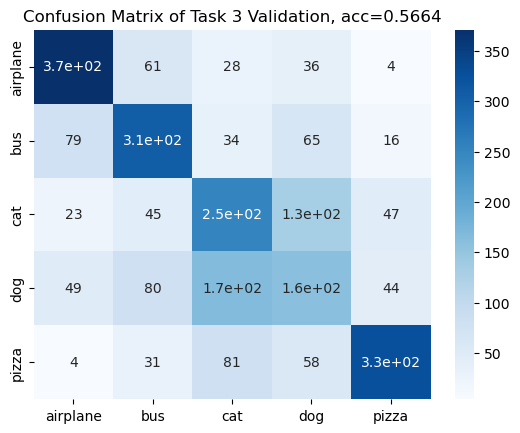

In [35]:
# task = 'task1'
# net = HW4Net(task)
# net = net.to(device)
# # load trained parameters 
# net.load_state_dict(torch.load(task+'.pth', map_location=torch.device(device))) 


root = 'D:/coco/hw4/val'
valdataset = hwDataset(root, 'validation')
val_data_loader = DataLoader(valdataset, batch_size=32, num_workers=0, shuffle=True)

confusion_matrix, acc = validation(net, val_data_loader)
print(acc)

plt.figure()
plt.title("Confusion Matrix of Task 3 Validation, acc="+str(acc)) 
sn.heatmap(confusion_matrix, annot=True, cmap="Blues",xticklabels=['airplane','bus','cat','dog','pizza'], yticklabels=['airplane','bus','cat','dog','pizza'])


In [30]:
loss_list1 = loss.copy()

In [33]:
loss_list2 = loss.copy()


In [36]:
loss_list3 = loss.copy()

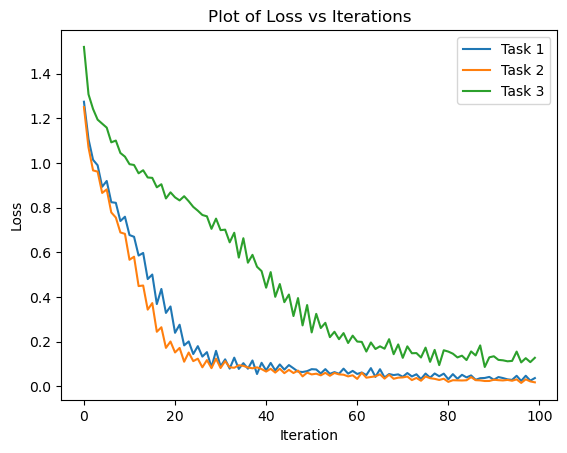

In [38]:
plt.plot(loss_list1, label='Task 1')
plt.plot(loss_list2, label='Task 2')
plt.plot(loss_list3, label='Task 3')
plt.legend()
plt.title("Plot of Loss vs Iterations")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [7]:
valdataset[2100]

(tensor([[[ 0.4745,  0.6078,  0.4431,  ...,  0.8275,  0.7333,  0.6549],
          [ 0.4824,  0.5922,  0.5137,  ...,  0.8510,  0.8275,  0.8039],
          [ 0.4353,  0.4824,  0.4745,  ...,  0.8039,  0.8510,  0.8824],
          ...,
          [-0.6314, -0.6392, -0.7333,  ..., -0.3804, -0.3882, -0.3961],
          [-0.5765, -0.5922, -0.6863,  ..., -0.4039, -0.4196, -0.4275],
          [-0.5373, -0.5922, -0.6706,  ..., -0.3804, -0.3882, -0.3961]],
 
         [[ 0.5922,  0.7255,  0.5608,  ...,  0.8980,  0.8039,  0.7255],
          [ 0.6000,  0.7098,  0.6314,  ...,  0.9216,  0.8980,  0.8745],
          [ 0.5529,  0.6000,  0.5922,  ...,  0.8902,  0.9373,  0.9686],
          ...,
          [-0.5373, -0.5451, -0.6549,  ..., -0.3020, -0.3098, -0.3176],
          [-0.4667, -0.4980, -0.5922,  ..., -0.3176, -0.3333, -0.3412],
          [-0.4275, -0.4980, -0.5765,  ..., -0.2941, -0.3020, -0.3098]],
 
         [[ 0.6314,  0.7647,  0.5843,  ...,  0.9373,  0.8431,  0.7647],
          [ 0.6392,  0.7490,